In [18]:
import warnings

In [20]:
warnings.filterwarnings('ignore')

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


In [40]:
# Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Update with the correct file path


In [42]:
df

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [44]:

# Debug: Print column names to identify the sales column
print("Original columns:", df.columns)

Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')


In [46]:
# Adjust column names based on actual dataset
# Replace 'Sales' with the actual sales column name
df.columns = ['DATE', 'Sales']  # Adjust if necessary

In [48]:
# Debug: Verify the updated DataFrame
print(df.head())


         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


In [50]:
# Plot the sales data
df['DATE'] = pd.to_datetime(df['DATE'])


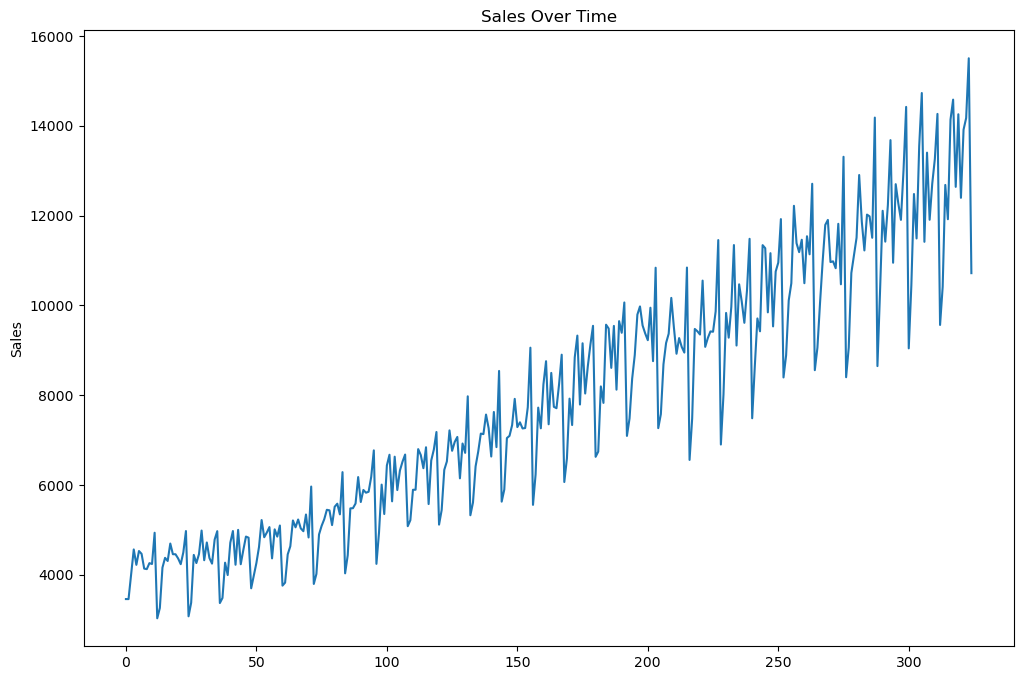

In [52]:
# Plot the data
plt.figure(figsize=(12, 8))  # Create a new figure
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')  # Title of the plot
plt.ylabel('Sales')  # Label for y-axis
plt.show()

In [54]:
# Create lag features for past months
df['Sale_LastMonth'] = df['Sales'].shift(+1)
df['Sale_2Monthsback'] = df['Sales'].shift(+2)
df['Sale_3Monthback'] = df['Sales'].shift(+3)

In [56]:
df.head()

,DATE,Sales,Sale_LastMonth,Sale_2Monthsback,Sale_3Monthback
0,1992-01-01,3459,NaN,NaN,NaN
1,1992-02-01,3458,3459.0,NaN,NaN
2,1992-03-01,4002,3458.0,3459.0,NaN
3,1992-04-01,4564,4002.0,3458.0,3459.0
4,1992-05-01,4221,4564.0,4002.0,3458.0


In [58]:
# Drop rows with missing values (due to shifting)
df = df.dropna()

In [60]:
df.head()

,DATE,Sales,Sale_LastMonth,Sale_2Monthsback,Sale_3Monthback
3,1992-04-01,4564,4002.0,3458.0,3459.0
4,1992-05-01,4221,4564.0,4002.0,3458.0
5,1992-06-01,4529,4221.0,4564.0,4002.0
6,1992-07-01,4466,4529.0,4221.0,4564.0
7,1992-08-01,4137,4466.0,4529.0,4221.0


In [62]:
# Prepare input (X) and output (y)
x = df.iloc[:, 2:].values  # Lag features
y = df.iloc[:, 1:2].values  # Current sales


In [64]:
# Split the data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)


In [66]:
# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [68]:
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)


In [70]:
# Reshape input for LSTM (samples, time steps, features)
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [72]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(xtrain.shape[1], 1)),
    Dropout(0.2),  # Dropout for regularization
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

In [74]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [76]:
# Train the model
model.fit(xtrain, ytrain, epochs=100, batch_size=5, validation_data=(xtest, ytest))


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1758 - mean_absolute_error: 0.3443 - val_loss: 0.0259 - val_mean_absolute_error: 0.1355
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - mean_absolute_error: 0.1273 - val_loss: 0.0158 - val_mean_absolute_error: 0.1035
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0975 - val_loss: 0.0074 - val_mean_absolute_error: 0.0651
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0871 - val_loss: 0.0073 - val_mean_absolute_error: 0.0649
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - mean_absolute_error: 0.0812 - val_loss: 0.0064 - val_mean_absolute_error: 0.0593
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0738 - val_loss: 0.0061 - val_mean_absolute_error: 0.0586
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0774 - val_loss

In [78]:
# Evaluate the model
loss, mae = model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0634 
Test Loss: 0.007433464750647545, Test MAE: 0.06362766027450562


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


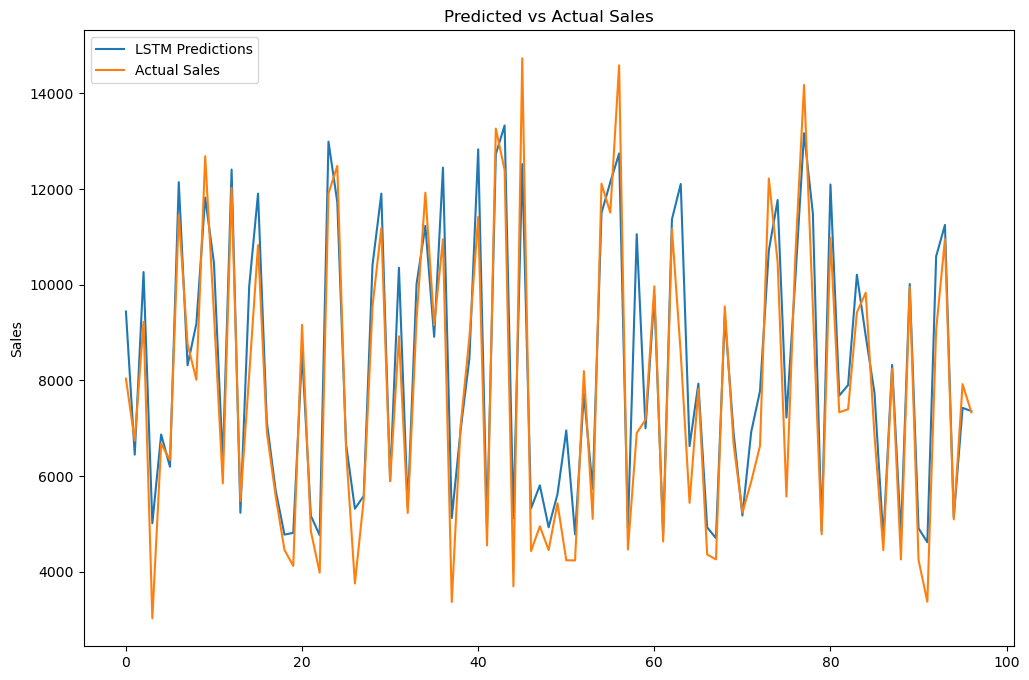

In [80]:
# Predict and plot results
predict = model.predict(xtest)
predict_rescaled = scaler_y.inverse_transform(predict)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predict_rescaled, label='LSTM Predictions')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend(loc='upper left')
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()

## With hyperParameter Optimization

Trial 10 Complete [00h 00m 08s]
val_loss: 0.0060482332482934

Best val_loss So Far: 0.0059289392083883286
Total elapsed time: 00h 01m 22s

The optimal number of units in the LSTM layer is 128,
dropout rate is 0.30000000000000004,
and the number of units in the dense layer is 48.

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1224 - mean_absolute_error: 0.2808 - val_loss: 0.0265 - val_mean_absolute_error: 0.1367
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mean_absolute_error: 0.1259 - val_loss: 0.0087 - val_mean_absolute_error: 0.0732
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - mean_absolute_error: 0.0792 - val_loss: 0.0064 - val_mean_absolute_error: 0.0602
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0794 - val_loss: 0.0066 - val_mean_absolute_error: 0.0609
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0807 - val_loss: 0.0062 - val_me

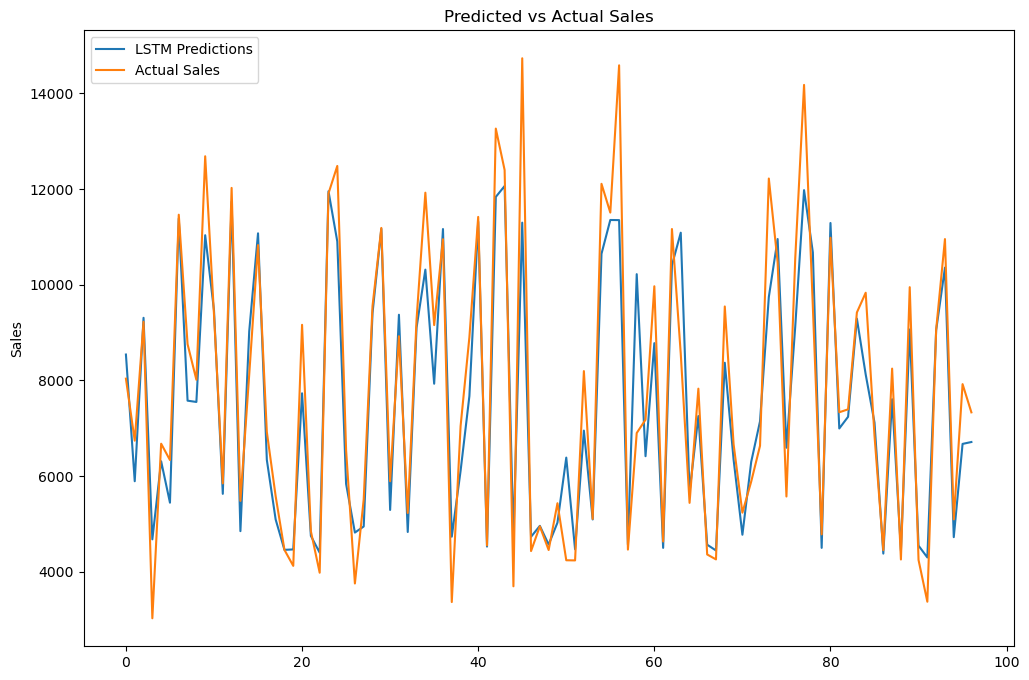

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

# Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Update with the correct file path

# Debug: Print column names to identify the sales column
print("Original columns:", df.columns)

# Adjust column names based on actual dataset
df.columns = ['DATE', 'Sales']  # Adjust if necessary

# Debug: Verify the updated DataFrame
print(df.head())

# Plot the sales data
df['DATE'] = pd.to_datetime(df['DATE'])

plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Create lag features for past months
df['Sale_LastMonth'] = df['Sales'].shift(+1)
df['Sale_2Monthsback'] = df['Sales'].shift(+2)
df['Sale_3Monthback'] = df['Sales'].shift(+3)

# Drop rows with missing values (due to shifting)
df = df.dropna()

# Prepare input (X) and output (y)
x = df.iloc[:, 2:].values  # Lag features
y = df.iloc[:, 1:2].values  # Current sales

# Split the data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape input for LSTM (samples, time steps, features)
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Hyperparameter tuning function
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=16),
            activation='relu',
            input_shape=(xtrain.shape[1], 1)
        ),
        Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
            activation='relu'
        ),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning'
)

# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')},
dropout rate is {best_hps.get('dropout')},
and the number of units in the dense layer is {best_hps.get('dense_units')}.
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(xtrain, ytrain, epochs=100, batch_size=5, validation_data=(xtest, ytest))

# Evaluate the model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict and plot results
predict = best_model.predict(xtest)
predict_rescaled = scaler_y.inverse_transform(predict)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predict_rescaled, label='LSTM Predictions')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend(loc='upper left')
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()


Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


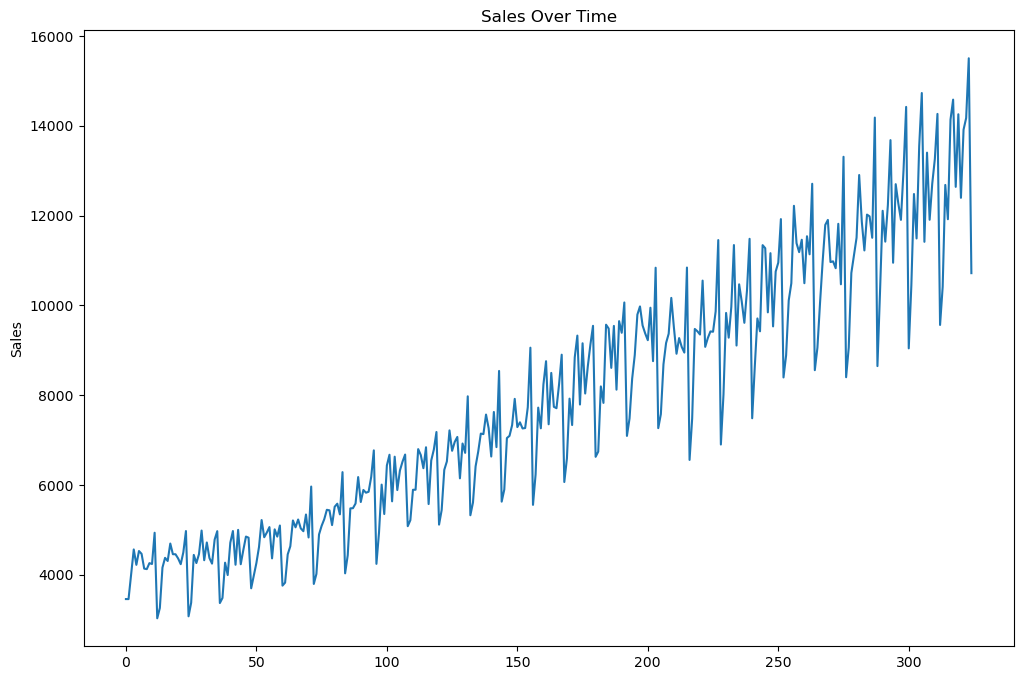

Reloading Tuner from my_dir/lstm_sales_tuning/tuner0.json

The optimal number of units in the LSTM layer is 128,
dropout rate is 0.30000000000000004,
and the number of units in the dense layer is 48.

Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1344 - mean_absolute_error: 0.2967 - val_loss: 0.0242 - val_mean_absolute_error: 0.1310
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - mean_absolute_error: 0.1154 - val_loss: 0.0094 - val_mean_absolute_error: 0.0750
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0858 - val_loss: 0.0066 - val_mean_absolute_error: 0.0611
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - mean_absolute_error: 0.0799 - val_loss: 0.0063 - val_mean_absolute_error: 0.0594
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0749 - val_loss: 0.0063 - val_mean_absolute_error: 0.0598
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

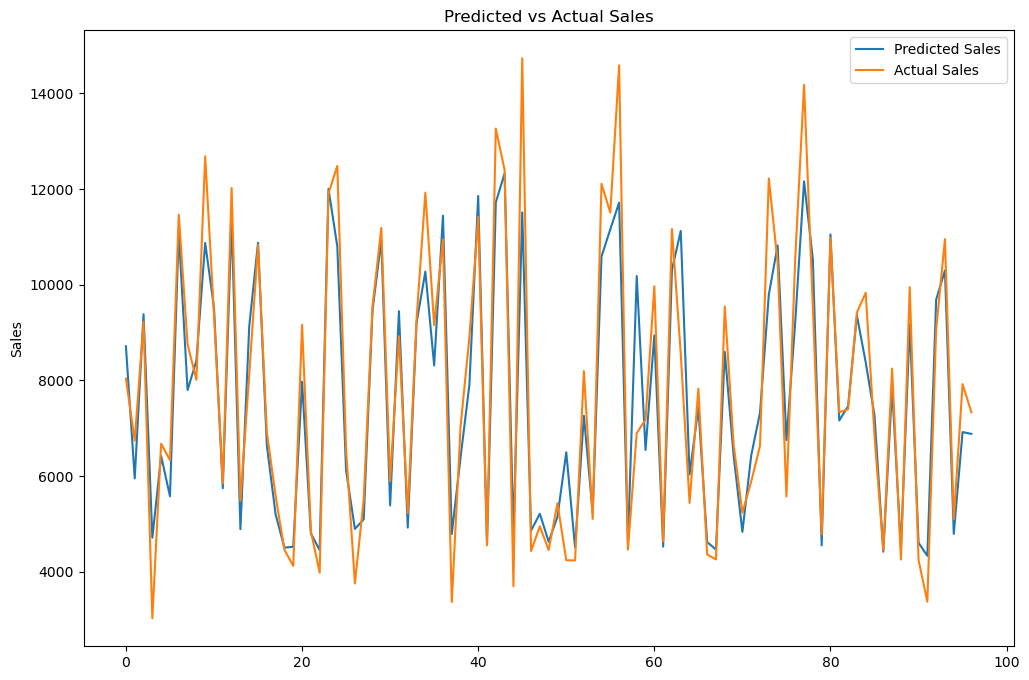

In [97]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

# Step 1: Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Ensure the file path is correct

# Step 2: Explore and preprocess the data
print("Original columns:", df.columns)  # Display column names
df.columns = ['DATE', 'Sales']  # Rename columns if needed
print(df.head())  # Display the first few rows

# Convert the DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Plot the sales data
plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Step 3: Create lagged features
df['Sale_LastMonth'] = df['Sales'].shift(1)
df['Sale_2Monthsback'] = df['Sales'].shift(2)
df['Sale_3Monthback'] = df['Sales'].shift(3)

# Drop rows with missing values due to shifting
df = df.dropna()

# Step 4: Prepare the data
x = df.iloc[:, 2:].values  # Use lagged features as input
y = df.iloc[:, 1:2].values  # Use current sales as target

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape the data for LSTM input
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Step 5: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=16),
        activation='relu',
        input_shape=(xtrain.shape[1], 1)
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# Step 6: Hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning'
)

# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')},
dropout rate is {best_hps.get('dropout')},
and the number of units in the dense layer is {best_hps.get('dense_units')}.
""")

# Step 7: Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xtrain, ytrain, epochs=60, batch_size=5, validation_data=(xtest, ytest))

# Step 8: Evaluate the best model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Step 9: Predict and visualize results
predictions = best_model.predict(xtest)
predictions_rescaled = scaler_y.inverse_transform(predictions)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend()
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()


## Hyper-Parameter Optimization

In [100]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt


In [102]:
# Step 1: Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Ensure the file path is correct

In [104]:
df

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [106]:
# Step 2: Explore and preprocess the data
print("Original columns:", df.columns)  # Display column names
df.columns = ['DATE', 'Sales']  # Rename columns if needed
print(df.head())  # Display the first few rows

Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


In [108]:
# Convert the DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

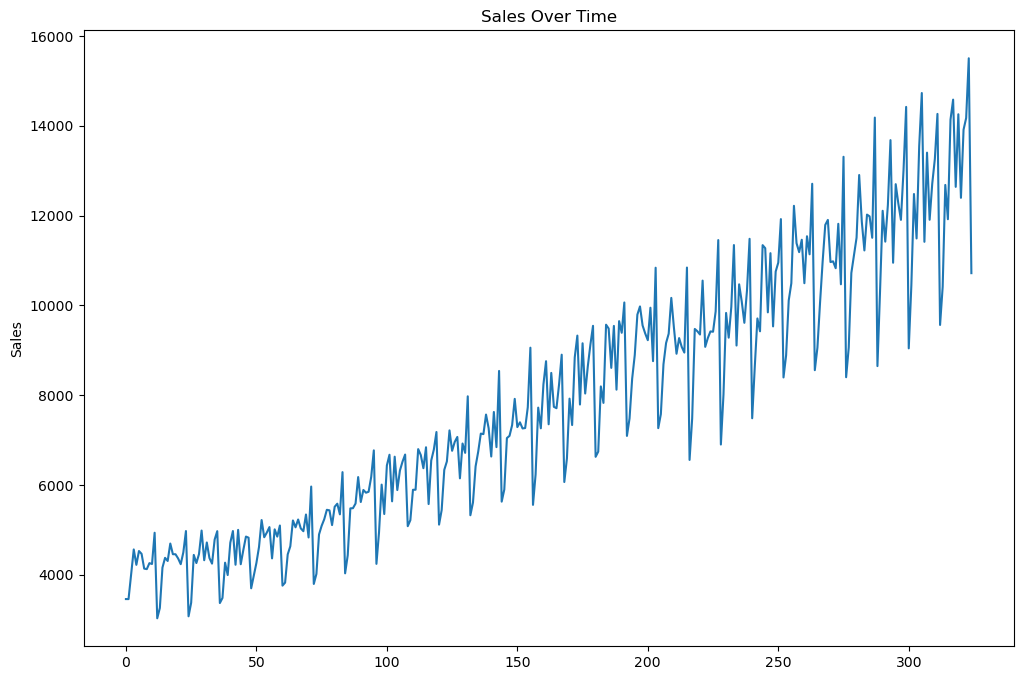

In [110]:
# Plot the sales data
plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

In [112]:
# Step 3: Create lagged features
df['Sale_LastMonth'] = df['Sales'].shift(1)
df['Sale_2Monthsback'] = df['Sales'].shift(2)
df['Sale_3Monthback'] = df['Sales'].shift(3)

In [114]:
# Drop rows with missing values due to shifting
df = df.dropna()

In [116]:
# Step 4: Prepare the data
x = df.iloc[:, 2:].values  # Use lagged features as input
y = df.iloc[:, 1:2].values  # Use current sales as target

In [118]:
# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)


In [120]:
# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)


In [122]:
# Reshape the data for LSTM input
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [124]:
# Step 5: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=16),
        activation='relu',
        input_shape=(xtrain.shape[1], 1)
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

In [126]:
# Step 6: Hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning'
)


Reloading Tuner from my_dir/lstm_sales_tuning/tuner0.json


In [128]:
# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

In [130]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')},
dropout rate is {best_hps.get('dropout')},
and the number of units in the dense layer is {best_hps.get('dense_units')}.
""")


The optimal number of units in the LSTM layer is 128,
dropout rate is 0.30000000000000004,
and the number of units in the dense layer is 48.



In [132]:
# Step 7: Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xtrain, ytrain, epochs=60, batch_size=5, validation_data=(xtest, ytest))

Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1202 - mean_absolute_error: 0.2720 - val_loss: 0.0198 - val_mean_absolute_error: 0.1175
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - mean_absolute_error: 0.1120 - val_loss: 0.0073 - val_mean_absolute_error: 0.0655
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - mean_absolute_error: 0.0769 - val_loss: 0.0064 - val_mean_absolute_error: 0.0598
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - mean_absolute_error: 0.0821 - val_loss: 0.0092 - val_mean_absolute_error: 0.0734
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0829 - val_loss: 0.0067 - val_mean_absolute_error: 0.0638
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - mean_absolute_error: 0.0877 - val_loss: 0.0065 - val_mean_absolute_error: 0.0591
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - mean_absolute_error: 0.0779 - val_loss: 0.006

In [134]:
# Step 8: Evaluate the best model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - mean_absolute_error: 0.0655 
Test Loss: 0.007829130627214909, Test MAE: 0.06593289971351624


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


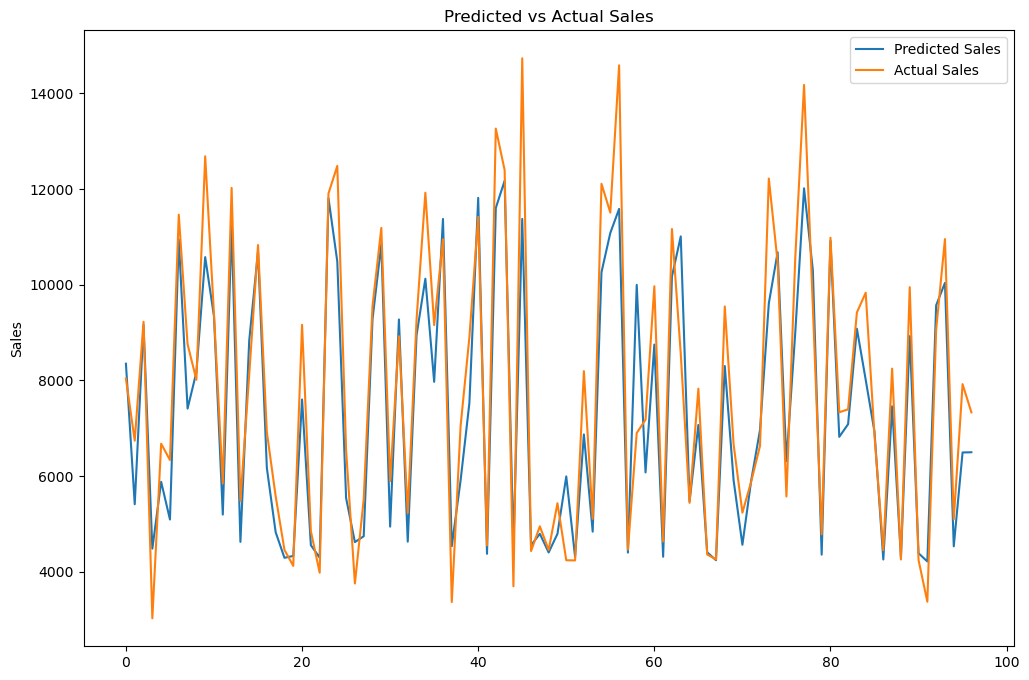

In [136]:
# Step 9: Predict and visualize results
predictions = best_model.predict(xtest)
predictions_rescaled = scaler_y.inverse_transform(predictions)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend()
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()